In [2]:
import pandas as pd 
import numpy as np 
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import matplotlib.scale as scale
%matplotlib inline
from statsmodels.tsa.stattools import coint
import statsmodels.formula.api as smf
import scipy.stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

In [37]:
def collect_coinmetrics():
    # Get Price Data
    coinmetrics_df = pd.read_csv('data/Coinmetrics/Coinmetrics_btc.csv', usecols=['time','PriceUSD'], index_col=False)
    coinmetrics_df.time = pd.to_datetime(coinmetrics_df.time, dayfirst = True)
    coinmetrics_df.index = coinmetrics_df.time
    coinmetrics_df.index = coinmetrics_df.index.tz_localize(None)
    return coinmetrics_df


def collect_blockchair():
    # Get Block by Block Data
    df = pd.read_csv('data/Blockchair/blockchair.csv')
    df.time = pd.to_datetime(df.time, dayfirst=True)
    df.index = df.time
    return df


def s2f_generation_halved_time_series_model(blockchair_df, coinmetrics_df, tf):
    """
    Inputs:
    blockchair_df (dataframe): 'blockchair.csv' dataframe declaration as well as a timeframe.
    coinmetrics_df (dataframe): 'coinmetrics_btc.csv' dataframe
    tf (timeframe): accepts the following strings: 'D', 'W', 'M' and 'Y' depending on the necessary granularity.

    Outputs:
    Returns a new dataframe with new columns computing S2F, S2F Multiples, Z-Scores and OLS Regression
    """

    final_timestamp = blockchair_df.time.iloc[-1:].dt.strftime('%Y-%m-%d').values[0]
    # Extend the timestamp index of the dataframe up to next generation
    temp_df = pd.DataFrame({'time': pd.Series(['2026-01-31'])}, columns=blockchair_df.columns)
    temp_df.time = pd.to_datetime(temp_df['time'], dayfirst=True)
    temp_df.index = temp_df.time
    temp2_df = blockchair_df.iloc[-1:].append(temp_df)
    df = blockchair_df.append(temp2_df.asfreq('D').iloc[1:])

    df1 = df.resample(tf)['generation'].sum().to_frame()  # get number of blocks produced in a certain time frame

    # Assume future generation is the average of a two year period between 2017-10-08 and 2019-10-08
    average_generation = df1['generation'].loc['2017-10-08':'2019-10-08'].mean()

    # Fill in generation estimates
    df1['generation'].loc[final_timestamp:'2020-5-18'] = average_generation
    df1['generation'].loc['2020-5-18':'2024-5-18'] = average_generation / 2
    df1['generation'].loc['2024-5-18':] = average_generation / 4

    df1['stock'] = df1.generation.cumsum()  # get running total of stock

    if tf == 'W':
        df1['year_flow'] = df1.generation.rolling(52).sum()
    elif tf == 'M':
        df1['year_flow'] = df1.generation.rolling(12).sum()
    elif tf == 'D':
        df1['year_flow'] = df1.generation.rolling(365).sum()
    if tf == 'Y':
        df1['year_flow'] = df1.generation.rolling(1).sum()

    def difference(df, s):  # Take a column as input
        return [((df[s][i] - df[s][i - 1]) / df[s][i - 1]) for i in range(len(df))]

    df1['s2f'] = df1.stock / df1.year_flow
    df1['s2f_log'] = np.log(df1.s2f)
    df1['s2f_dif'] = difference(df1, 's2f')
    prices = coinmetrics_df.resample(tf)['PriceUSD'].mean().to_frame()
    prices = prices.append(temp_df)
    prices = prices.append(prices.iloc[-2:].asfreq('D').iloc[1:])
    df2 = pd.merge(prices, df1, left_index=True, right_index=True, how='inner')

    df2['price_log'] = np.log(df2['PriceUSD'])
    df2['price_dif'] = difference(df2, 'PriceUSD')
    df2['s2f_price_dif'] = df2.s2f_dif / df2.price_dif
    df2['s2f_multiple'] = df2.s2f_log / df2.price_log
    df2['s2f_zscore'] = scipy.stats.zscore(df2.s2f_multiple)

    # OLS Regression
    df2['X'] = df2.s2f_log.values.reshape(-1, 1)
    df2['Y'] = df2.price_log.values.reshape(-1, 1)

    est = smf.ols(formula='Y ~ X', data=df2.loc[:final_timestamp]).fit()
    df2['price_pred'] = est.predict(df2['X'])
    df2['price_pred_dif'] = np.nan
    df2['price_pred_dif_zscore'] = np.nan
    df2['price_pred_dif'].loc[:'2019-10-01'] = df2.price_pred.loc[:final_timestamp] - df2.Y.loc[:final_timestamp]
    df2['price_pred_dif_zscore'][df2.price_pred_dif.notna()] = scipy.stats.zscore(
        df2.price_pred_dif.dropna().loc[:final_timestamp])

    # Create column 'Days until next halving' of the generation
    df2['days_until_next_halving'] = np.nan

    # Future dates are just estimates
    halving_dates = [datetime(2012, 11, 28), datetime(2016, 7, 9), datetime(2020, 5, 18)]
    prev_date = df2.index[0]
    for i in range(len(halving_dates)):
        date = halving_dates[i]
        if date > df2.index[-1]:
            df2['days_until_next_halving'].loc[prev_date:df2.index[-1]] = date - df2.loc[prev_date:df2.index[-1]].index
        else:
            df2['days_until_next_halving'].loc[prev_date:date] = date - df2.loc[prev_date:date].index
        prev_date = date

    df2['days_until_next_halving'] = pd.to_timedelta(df2['days_until_next_halving']).dt.days

    fig = make_subplots()

    # Add traces
    fig.add_trace(go.Scatter(x=df2['PriceUSD'].dropna().index,
                             y=df2['PriceUSD'].dropna(),
                             mode='lines+markers',
                             showlegend=True,
                             marker=dict(size=3,
                                         color=df2['price_pred_dif_zscore'],  # set color equal to a variable
                                         colorscale='viridis',  # one of plotly colorscales
                                         colorbar=dict(title='price_pred_dif_zscore', titleside="right"),
                                         showscale=True)
                             ))

    fig.add_trace(go.Scatter(x=df2['PriceUSD'].dropna().index,
                             y=df2['PriceUSD'].dropna(),
                             mode='lines+markers',
                             showlegend=True,
                             marker=dict(size=2,
                                         color=df2['days_until_next_halving'],  # set color equal to a variable
                                         colorscale='Rainbow',  # one of plotly colorscales
                                         colorbar=dict(x=1.15, title='days_until_next_halving', titleside="right"),
                                         showscale=True)
                             ))

    fig.add_trace(go.Scatter(x=df2.index,
                             y=np.exp(df2['price_pred']),
                             mode='lines',
                             showlegend=True,
                             ))

    fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time", font=dict(size=14))),
                      yaxis=go.layout.YAxis(type='log', title=go.layout.yaxis.Title(text="price_log", font=dict(size=14))),
                      legend=dict(x=0.85, y=0.1))

    return fig, df2

In [4]:
blockchair_df, coinmetrics_df = collect_blockchair(), collect_coinmetrics()

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\IPython\core\interactiveshell.py:3249: DtypeWarning:

Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.



C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\ipykernel_launcher.py:85: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



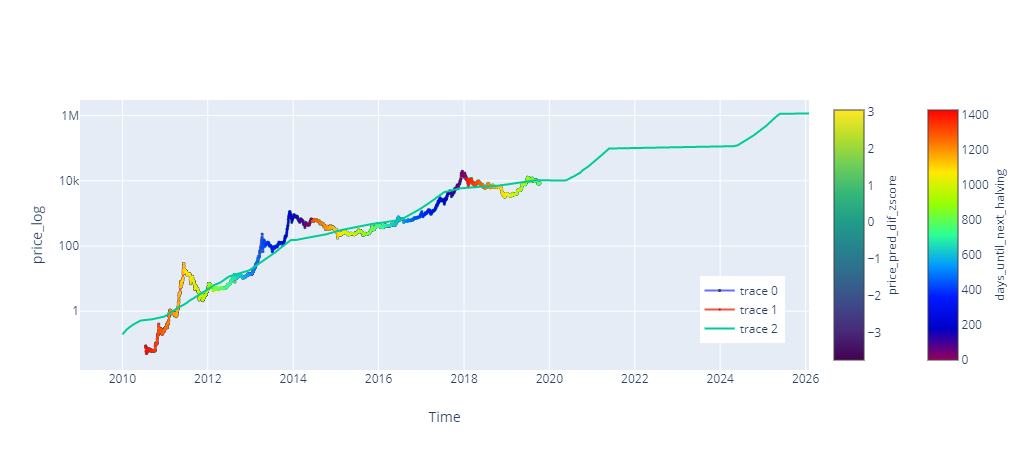

In [39]:
fig, df2 = s2f_generation_halved_time_series_model(blockchair_df, coinmetrics_df, 'D')
fig.show()

In [57]:
# Get Price Data
coinmetrics_df = pd.read_csv('data/Coinmetrics/Coinmetrics_btc.csv', usecols=['time','PriceUSD'], index_col=False)
coinmetrics_df.time = pd.to_datetime(coinmetrics_df.time, dayfirst = True)
coinmetrics_df.index = coinmetrics_df.time
coinmetrics_df.index = coinmetrics_df.index.tz_localize(None)

In [18]:
# Get Block by Block Data
df = pd.read_csv('data/Blockchair/blockchair.csv')
df.time = pd.to_datetime(df.time, dayfirst=True)
df.index = df.time

In [138]:
def s2f_generation_halved_time_series_model(df, tf): 
    """ 
    Inputs: 
    df (dataframe): 'blockchair.csv' dataframe declaration as well as a timeframe. 
    tf (timeframe): accepts the following strings: 'D', 'W', 'M' and 'Y' depending on the necessary granularity. 
    
    Outputs: 
    Returns a new dataframe with new columns computing S2F, S2F Multiples, Z-Scores and OLS Regression
    """
    
    final_timestamp = df.time.iloc[-1:].dt.strftime('%Y-%m-%d').values[0]
    # Extend the timestamp index of the dataframe up to next generation
    temp_df = pd.DataFrame({'time': pd.Series(['2026-01-31'])}, columns=df.columns)
    temp_df.time = pd.to_datetime(temp_df['time'], dayfirst=True)
    temp_df.index = temp_df.time
    temp2_df = df.iloc[-1:].append(temp_df)
    df = df.append(temp2_df.asfreq('D').iloc[1:])
    
    df1 = df.resample(tf)['generation'].sum().to_frame()   # get number of blocks produced in a certain time frame 
    
    # Assume future generation is the average of a two year period between 2017-10-08 and 2019-10-08
    average_generation = df1['generation'].loc['2017-10-08':'2019-10-08'].mean()
    
    # Fill in generation estimates
    df1['generation'].loc[final_timestamp:'2020-5-18'] = average_generation
    df1['generation'].loc['2020-5-18':'2024-5-18'] = average_generation / 2
    df1['generation'].loc['2024-5-18':] = average_generation / 4
    
    df1['stock'] = df1.generation.cumsum() # get running total of stock

    if tf == 'W':
        df1['year_flow'] = df1.generation.rolling(52).sum()
    elif tf == 'M':
        df1['year_flow'] = df1.generation.rolling(12).sum()
    elif tf == 'D':
        df1['year_flow'] = df1.generation.rolling(365).sum()
    if tf == 'Y':
        df1['year_flow'] = df1.generation.rolling(1).sum()

    def difference(df, s): # Take a column as input
        return [((df[s][i] - df[s][i-1])/df[s][i-1]) for i in range(len(df))]

    df1['s2f'] = df1.stock / df1.year_flow
    df1['s2f_log'] = np.log(df1.s2f)
    df1['s2f_dif'] = difference(df1, 's2f')
    prices = coinmetrics_df.resample(tf)['PriceUSD'].mean().to_frame()
    prices = prices.append(temp_df)
    prices = prices.append(prices.iloc[-2:].asfreq('D').iloc[1:])
    df2 = pd.merge(prices, df1, left_index= True, right_index= True, how='inner')

    df2['price_log'] = np.log(df2['PriceUSD'])
    df2['price_dif'] = difference(df2, 'PriceUSD')
    df2['s2f_price_dif']= df2.s2f_dif / df2.price_dif
    df2['s2f_multiple'] = df2.s2f_log / df2.price_log
    df2['s2f_zscore'] = scipy.stats.zscore(df2.s2f_multiple)

    # OLS Regression
    df2['X'] = df2.s2f_log.values.reshape(-1,1)
    df2['Y'] = df2.price_log.values.reshape(-1,1)

    est = smf.ols(formula='Y ~ X', data=df2.loc[:final_timestamp]).fit()
    df2['price_pred'] = est.predict(df2['X'])
    df2['price_pred_dif'] = np.nan
    df2['price_pred_dif_zscore'] = np.nan
    df2['price_pred_dif'].loc[:'2019-10-01'] = df2.price_pred.loc[:final_timestamp] - df2.Y.loc[:final_timestamp]
    df2['price_pred_dif_zscore'][df2.price_pred_dif.notna()] = scipy.stats.zscore(df2.price_pred_dif.dropna().loc[:final_timestamp])

    # Create column 'Days until next halving' of the generation
    df2['days_until_next_halving'] = np.nan
    
    # Future dates are just estimates
    halving_dates = [datetime(2012,11,28), datetime(2016,7,9), datetime(2020,5,18)]
    prev_date = df2.index[0]
    for i in range(len(halving_dates)):
        date = halving_dates[i]
        if date > df2.index[-1]:
            df2['days_until_next_halving'].loc[prev_date:df2.index[-1]] = date - df2.loc[prev_date:df2.index[-1]].index
        else:
            df2['days_until_next_halving'].loc[prev_date:date] = date - df2.loc[prev_date:date].index
        prev_date = date
        
    df2['days_until_next_halving'] = pd.to_timedelta(df2['days_until_next_halving']).dt.days
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Add traces
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price_log'],
                             mode='lines+markers',
                             showlegend=True,
                             marker=dict(size=3,
                                         color=df2['price_pred_dif_zscore'], #set color equal to a variable
                                         colorscale='viridis', # one of plotly colorscales
                                         colorbar=dict(title='price_pred_dif_zscore', titleside="right"),
                                         showscale=True)
                            ),
                  secondary_y=True)
    
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price_log'],
                             mode='lines+markers',
                             showlegend=True,
                             marker=dict(size=2,
                                         color=df2['days_until_next_halving'], #set color equal to a variable
                                         colorscale='Rainbow', # one of plotly colorscales
                                         colorbar=dict(x=1.15, title='days_until_next_halving', titleside="right"),
                                         showscale=True)
                            ),
                  secondary_y=True)
    
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['price_pred'],
                             mode='lines',
                             showlegend=True,
                            ),
                  secondary_y=True)

    # This trace is for creating the left axis, should not be visibly plotted
    fig.add_trace(go.Scatter(x = df2.index,
                             y = df2['PriceUSD'],
                             showlegend=False,
                             mode='lines',
                             line=dict(width=0)
                            ),
                  secondary_y=False)

    fig.update_layout(xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text="Time",font=dict(size=14))),
                      yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text="price_log",font=dict(size=14))),
                      legend=dict(x=0.9, y=0.1))
    fig.update_yaxes(type='log',secondary_y=False)
    fig.update_yaxes(tickvals=[],secondary_y=True)
    fig.show()
    
    return df2

C:\Users\laide\Miniconda3\envs\venture_256\lib\site-packages\ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



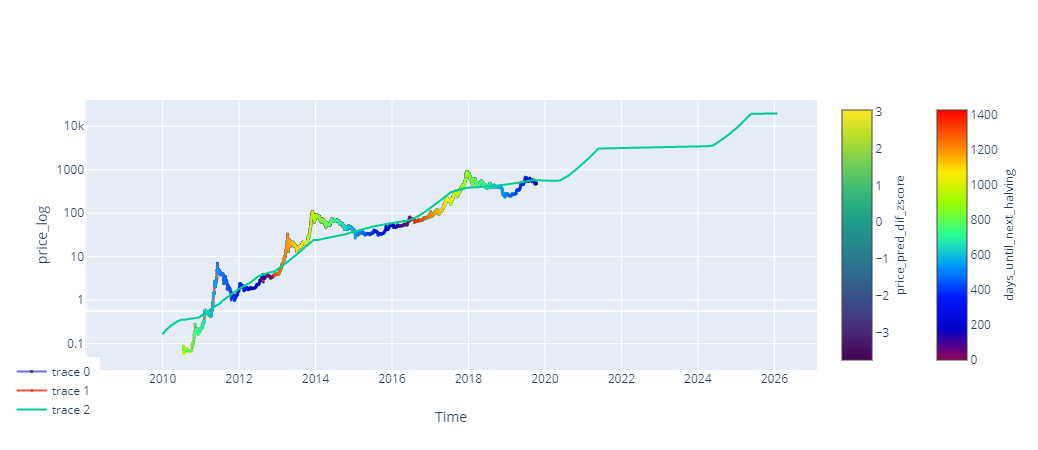

In [139]:
day2 = s2f_generation_halved_time_series_model(df, 'D')